# Medical Cost Prediction

&emsp;The [dataset](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv) contains `1338` individuals' information with `6` attributes. They are `age`, `sex`, `BMI`, `number of children`, `whether is a smoker`, `residential region`. The outcome variable is the medical cost. This project showed a promising predictive **linear regression** model for estimating medical cost. It can be useful for insurance companies and government to determine policy cost and to allocate resources respectively. 

&emsp;Eventually, after conducting **exploratory data analysis** and **feature engineering**, a new feature was created that may be related to `hospital choice`. Together with `age` and `whether is a smoker`, a regression model with approximately 96.6% accuracy was built.

&emsp;Future work requires researching about the exact feature that was created. 

1. [Data Exploration](#explore)
2. [Clustering](#cluster)
3. [Model Training](#train)
4. [Model Evaluation & Interpretation](#eval-interpret)

In [38]:
# Import libraries
# data manipulations
import pandas as pd
import numpy as np
# visualization tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('fivethirtyeight')
%matplotlib inline
# clustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
# model building & evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
# Interactive Visualisation
import streamlit as st

# Data Exploration<a id='explore'></a>

In [39]:
# Import data
df = pd.read_csv("insurance.csv")
print("Feature data types:")
print(df.dtypes)
df.head(3)

Feature data types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [40]:
# Check for missing data
print("Number of missing value:", df.isna().sum().sum())

Number of missing value: 0


In [41]:
# Check values for each categorical feature
for feature in df.select_dtypes(include=object).columns:
    print(df[feature].value_counts().sort_index())
    print()

sex
female    662
male      676
Name: count, dtype: int64

smoker
no     1064
yes     274
Name: count, dtype: int64

region
northeast    324
northwest    325
southeast    364
southwest    325
Name: count, dtype: int64



* The dataset contains no missing values.  
* There are 3 categorical features as shown above.

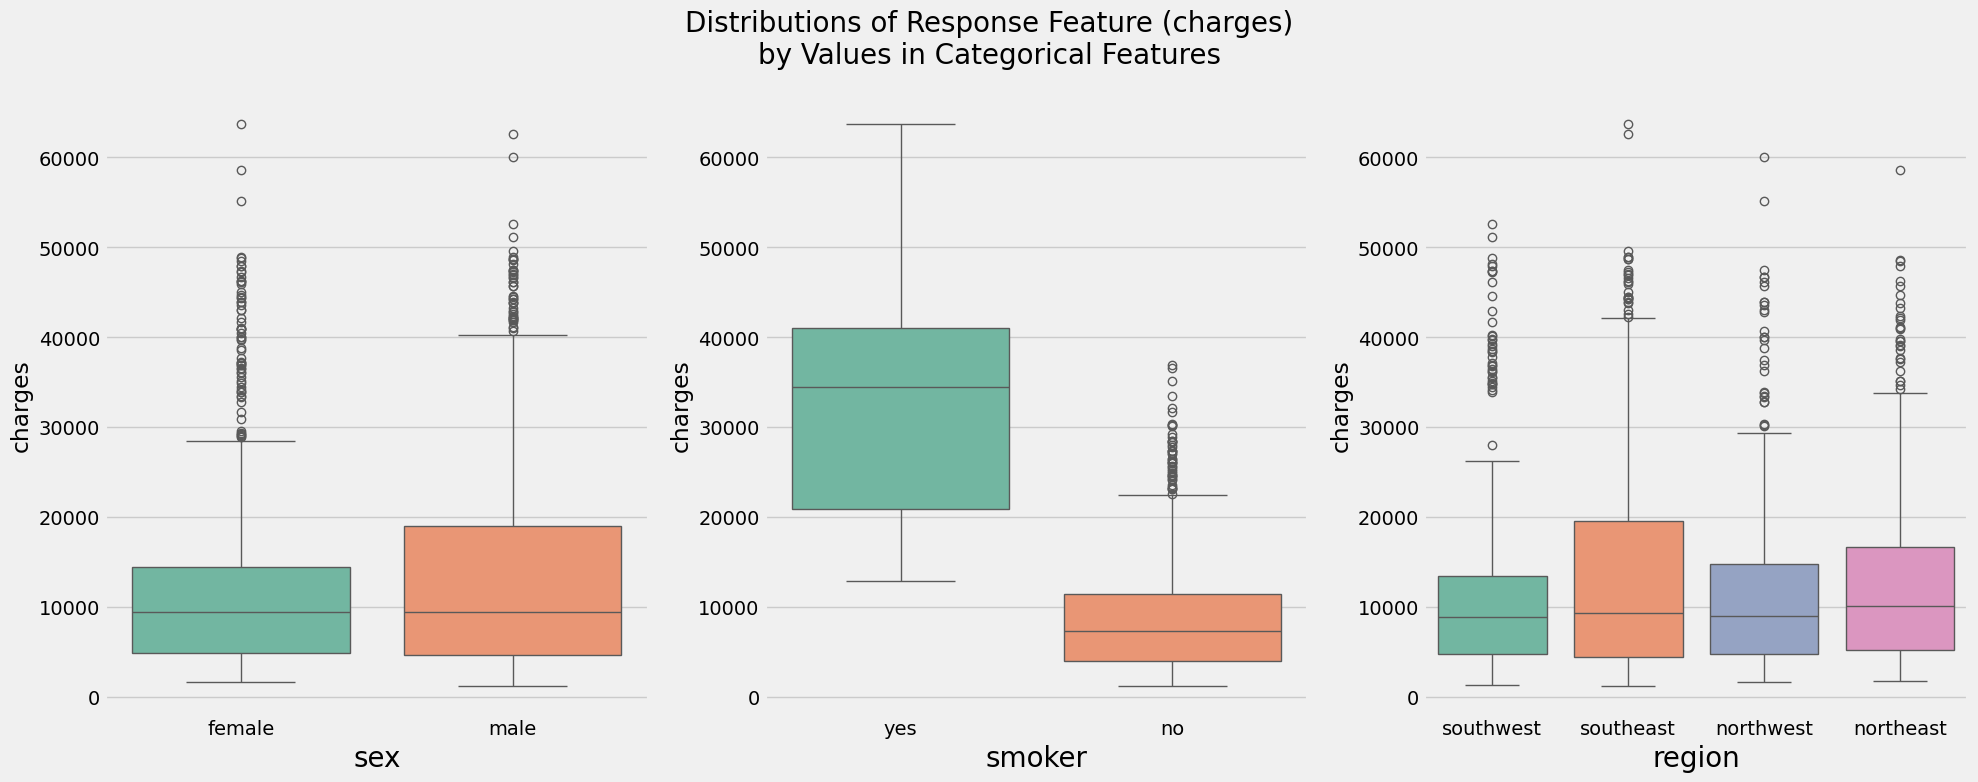

In [42]:
# Boxplots for categorical features
fig = plt.figure(figsize=(20,8))
for i, feature in enumerate(df.select_dtypes(include=object).columns):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(df, x=feature, y='charges', hue=feature, palette=sns.color_palette('Set2', n_colors=len(df[feature].value_counts().index)), ax=ax)
    ax.set_xlabel(feature, fontsize=20)
fig.suptitle("Distributions of Response Feature (charges)\nby Values in Categorical Features", fontsize=20)
fig.tight_layout()
plt.show()

&emsp;Simply looking at the distributions from the boxplots, there is a clear difference in the distributions of medical costs between smokers and non-smokers. Thus, **smoker** seems to be a promising feature for the training the model. Apart from this apparent difference, people who are males in **sex** seems to have higher medical costs in general.

In [43]:
# Convert categorical features as dummy variables
df_dummies = pd.get_dummies(df, dtype=int)
# Rearrange response variable to the last column
#   - looks tedious here :-)
y = df_dummies['charges']
df_dummies = df_dummies.drop(columns=['charges'])
df_dummies = pd.concat([df_dummies, y], axis=1)
df_dummies.head(2)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,19,27.90,0,1,0,0,1,0,0,0,1,16884.9240
1,18,33.77,1,0,1,1,0,0,0,1,0,1725.5523


&emsp;After converting categorical features into numbers, correlation among features including response variable is shown to confirm above observation as well as to reveal response variable's relationship with the numeric features.

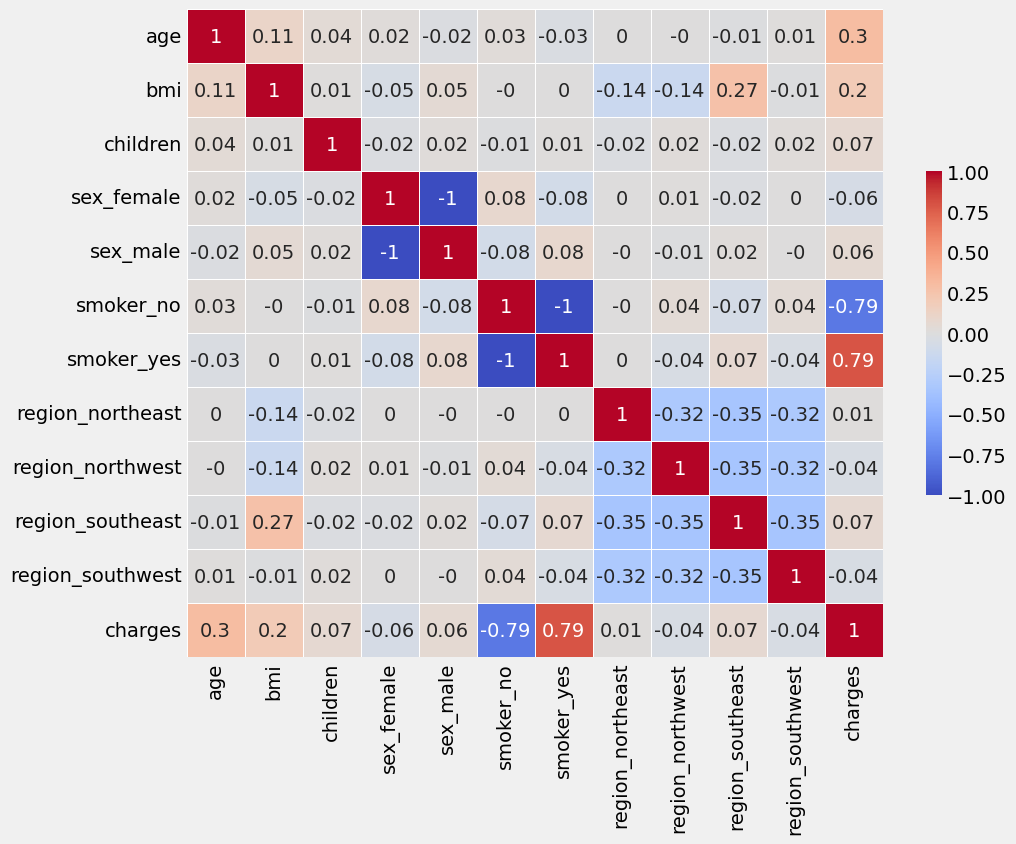

In [44]:
cor = round(df_dummies.corr(), 2)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cor, cmap='coolwarm', annot=True, vmin=-1, vmax=1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
ax.grid(False)
plt.show()

&emsp;By looking at the last row of the plot, number of children, sex, and region indicate insignificant relationship with the response variable, medical cost. The most significant pearson coefficients are shown in both the **smoker** dummy variables. One of them will be used to train the model. **Age** and **bmi** will also be considered in the process as they showed some correlation with the response variable. Further visualization will be done to examine and confirm the significance of the linear relationship.

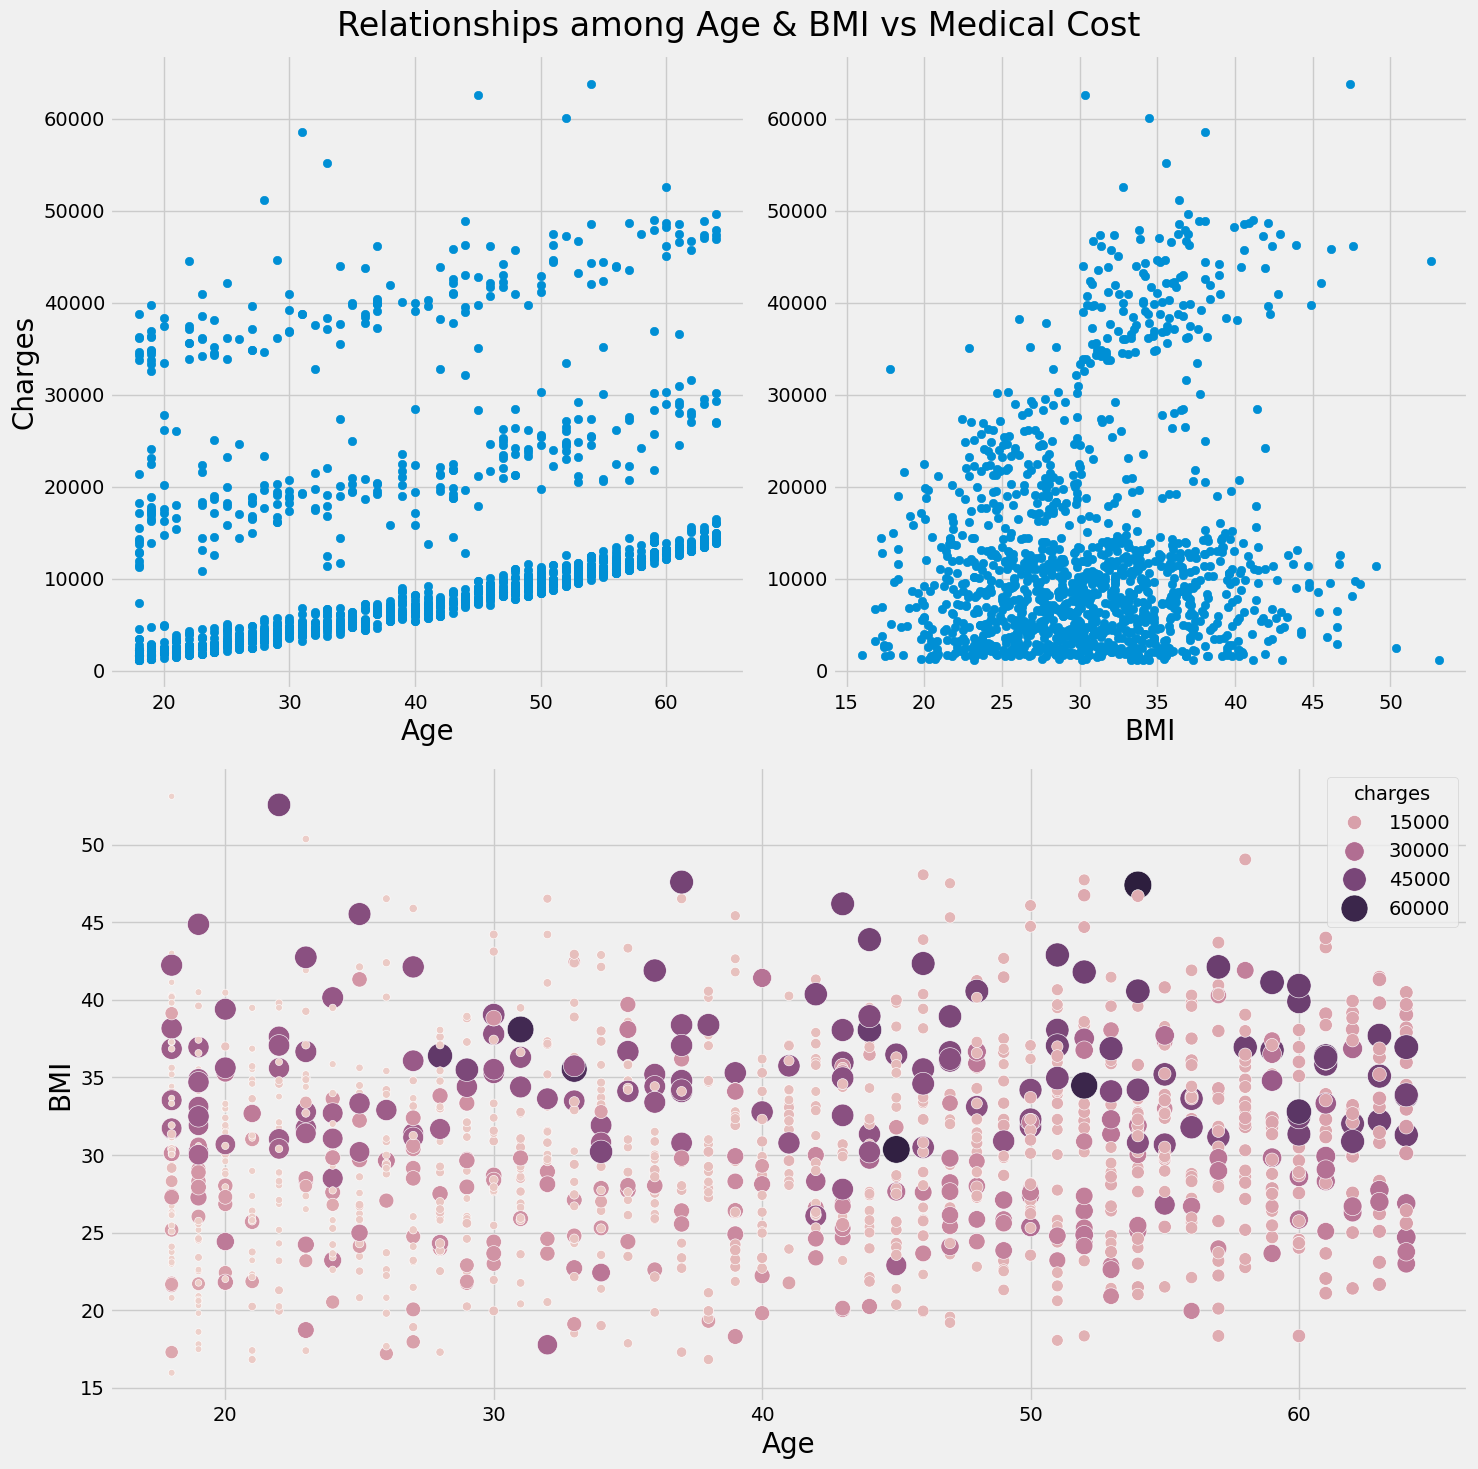

In [45]:
# Scatterplots for age and bmi versus charges
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(data=df_dummies, x='age', y='charges')
ax1.set_xlabel('Age', fontsize=20)
ax1.set_ylabel('Charges', fontsize=20)

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(data=df_dummies, x='bmi', y='charges')
ax2.set_xlabel('BMI', fontsize=20)

ax3 = fig.add_subplot(2,1,2)
sns.scatterplot(data=df_dummies, x='age', y='bmi', size='charges', sizes=(20,400), hue='charges', ax=ax3)
ax3.legend(title='charges', loc='best')
ax3.set_xlabel('Age', fontsize=20)
ax3.set_ylabel('BMI', fontsize=20)

fig.suptitle("Relationships among Age & BMI vs Medical Cost", fontsize=24)
fig.tight_layout()
plt.show()

&emsp;Simply looking at the relationships from the scatterplots, **BMI** does not show apparent linear relationship with charges. **Age** shows a positive relationship with charges; however, there is quite a wide variance in charges. Apparently, there are 3 trendlines in the plot. There may be another crucial feature(s) segmenting people into these 3 groups. As a result, before **Age** and **Smoker** are used to train the model, DBSCAN and Gaussian Mixture Model will be used to cluster the people into desirably 3 groups.<a id='charges-age'></a><a id='bmi'></a>

# Clustering<a id='cluster'></a>

In [46]:
# Scale features for DBSCAN 
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(df_dummies[['age','charges']]), columns=[['age','charges']])
# DBSCAN
db = DBSCAN()
clusters_db = db.fit_predict(scaled)
np.unique(clusters_db)

array([-1,  0])

In [47]:
# Gaussian Mixture Modelling 
gm = GaussianMixture(n_components=3)
clusters_gm = gm.fit_predict(df_dummies[['age','charges']])
np.unique(clusters_gm)

array([0, 1, 2])

&emsp;DBSCAN and Gaussian Mixture Model (GMM) clustering algorthms were used. DBSCAN auto discovers the number of clusters based on density whereas GMM is a distance based probabilistic model where covariance structure is taken into account (Baruah 2020). The number of clusters, 3, is chosen for GMM clustering based on the [visualization](#charges-age). DBSCSAN, on the other hand, detected 2 clusters. The relationship between **Age** and **Charges** are displayed again with the labels from the clustering algorithms.

In [48]:
df_dummies['db'] = clusters_db + 1
df_dummies['gm'] = clusters_gm

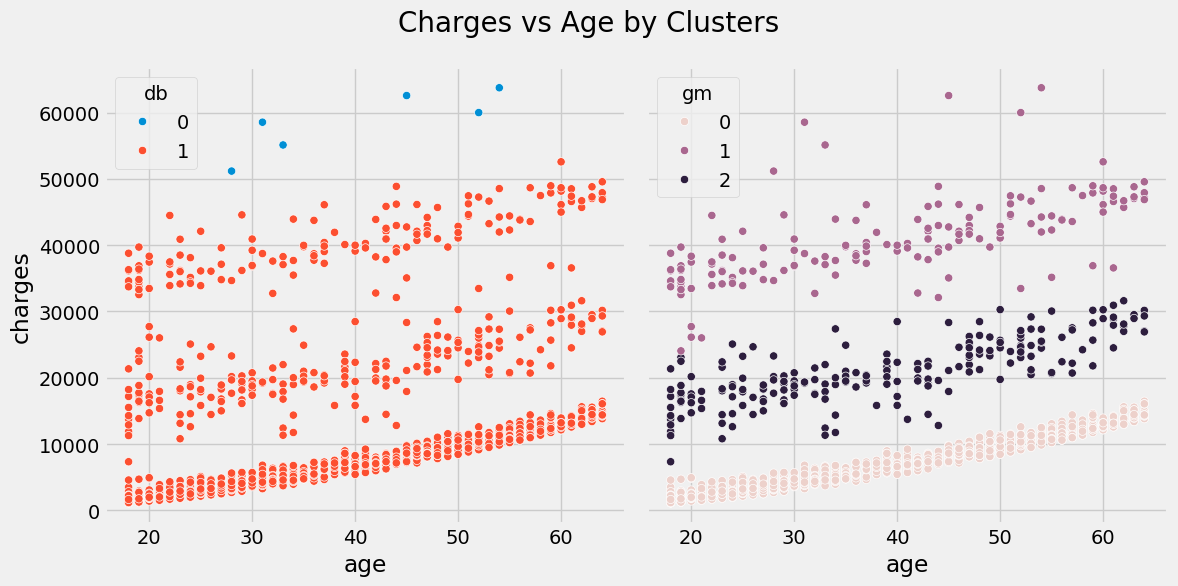

In [49]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x="age", y="charges", hue="db", data=df_dummies, ax=ax1)

ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x="age", y="charges", hue="gm", data=df_dummies, ax=ax2)
ax2.set_ylabel("")
ax2.set_yticklabels([])

fig.suptitle("Charges vs Age by Clusters", fontsize=20)
fig.tight_layout()
plt.show()

&emsp;DBSCAN, in this case, was only able to separate the scattered outliers from the three main trendlines. On the other hand, the GMM algorithm managed to label the data points from the trendlines into 3 clusters. Thus, the labels from GMM will be used for model training. Before training, the labels are conveted into dummy variables due to their nominal characteristic.

In [50]:
df_dummies.drop(columns=['db'], inplace=True)
df_dummies = pd.get_dummies(df_dummies, columns=['gm'], drop_first=True, dtype=int)
df_dummies.head(2)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges,gm_1,gm_2
0,19,27.90,0,1,0,0,1,0,0,0,1,16884.9240,0,1
1,18,33.77,1,0,1,1,0,0,0,1,0,1725.5523,0,0


# Model Training<a id='train'></a>

In [51]:
# Predictors and response variable
X = df_dummies.drop(columns=['charges'])
y = df_dummies['charges']
# Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=4)

In [52]:
# Fitting training data
lm = LinearRegression()
lm.fit(X_train[['smoker_yes','age','gm_1','gm_2']], y_train)
train_pred = lm.predict(X_train[['smoker_yes','age','gm_1','gm_2']])
print('Intercept =', lm.intercept_)
print('Coefficient =', lm.coef_)
print('Root mean squared error =', root_mean_squared_error(y_train, train_pred))
print('R squared =', r2_score(y_train, train_pred))

Intercept = -3660.0755779263545
Coefficient = [ 1269.2581945    272.49065242 32747.78892331 13319.73309646]
Root mean squared error = 2186.663991082925
R squared = 0.9682777290301015


&emsp;The root mean squared error of this preliminary model is 2205.27. Next, plotting a residual plot would testify the linearity assumption.

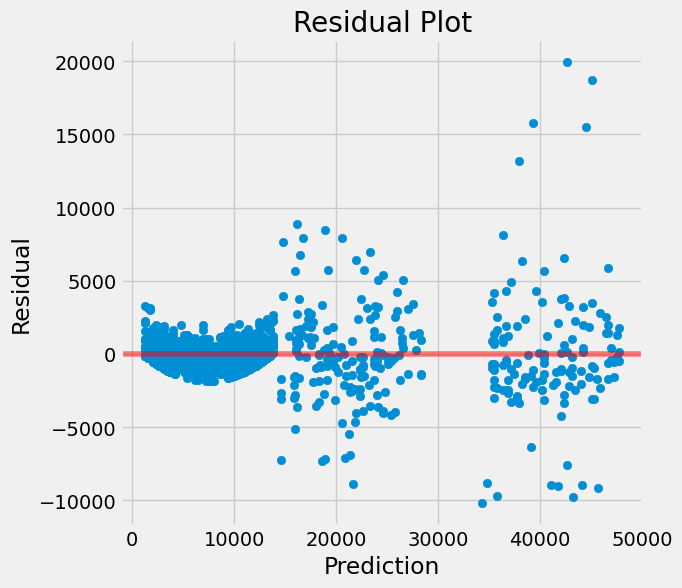

In [53]:
residuals = y_train - train_pred
plt.figure(figsize=(6,6))
plt.scatter(train_pred, residuals)
plt.axhline(0, color='r', alpha=.5)
plt.xlabel("Prediction")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.show()

&emsp;The residual plot gives a strange distribution of values. The gap may be caused by the strong effect of the categorical feature **Smoker**. The residuals with prediction values lower than 15000 shows a curve which indicates a non-linearity relationship between the medical costs and the predictors. Additionally, the residuals diverges as prediction values increases. This heteroscedasticity (non-uniform variance of residuals) may be addressed by additional feature or feature(s) transformation. Despite the residual plot violates the assumptions for a linear regression model, model is validated with unseen test data to review the performance. After that, improvement may be implemented accordingly.

# Model Evaluation & Interpretation<a id='eval-interpret'></a>

Root mean squared error = 2077.614400863382
R squared = 0.9665274845601886


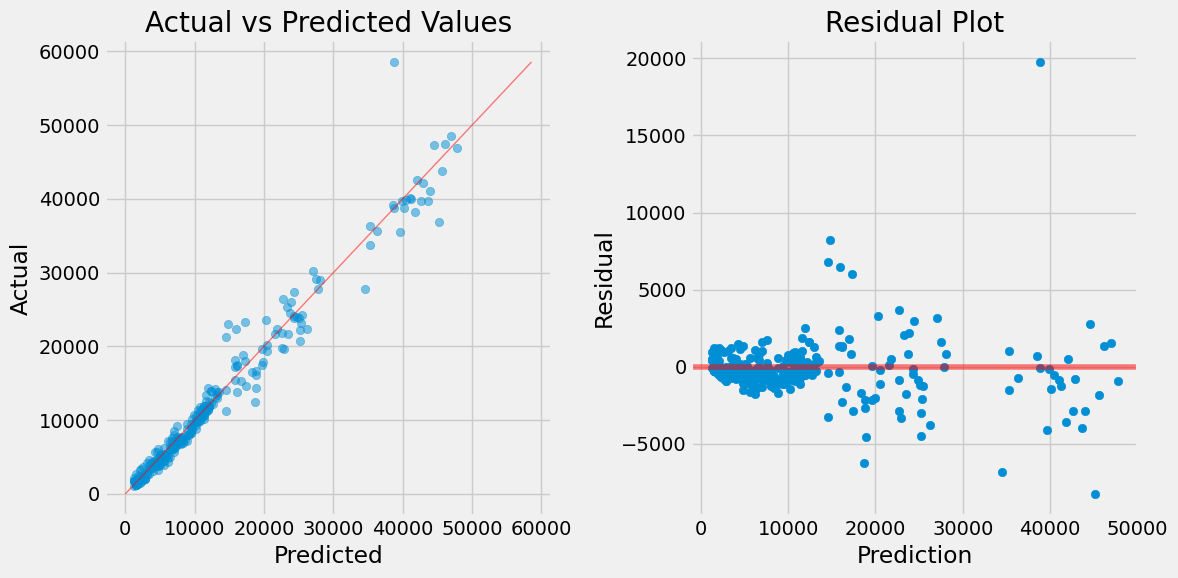

In [54]:
# Evaluate with test data
test_pred = lm.predict(X_test[['smoker_yes','age','gm_1','gm_2']])
print('Root mean squared error =', root_mean_squared_error(y_test, test_pred))
print('R squared =', r2_score(y_test, test_pred))

# Visualize accuracy and residuals
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].scatter(test_pred, y_test, alpha=.5)
axes[0].plot([0,y_test.max()],[0,y_test.max()], lw=1, color='red', alpha=.5)
axes[0].set_ylabel("Actual")
axes[0].set_xlabel("Predicted")
axes[0].set_title("Actual vs Predicted Values")

residuals = y_test - test_pred
axes[1].scatter(test_pred, residuals)
axes[1].axhline(0, color='r', alpha=.5)
axes[1].set_xlabel("Prediction")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residual Plot")

fig.tight_layout()
plt.show()

&emsp;The root mean squared error even improved when the prediction is carried out on test data. The coefficient of determination ($R^2$) decreases from .967 to .966 which means the model is not under- or over-fitted.  

&emsp;As shown in the Actual vs Predicted Values plot, the model seems to be able to accurately predict values in the low range of medical cost. This could be explained by sampling error which its sign is also shown and partially explained in the [scatterplot](#charges-age) previously which shows 3 separated trendlines. The bottom trendline is much denser than other two. Although all the trendlines gradually go up with age, the amount of medical cost differs. The potential reason to this could be explained by wealth of the people or their choices of medical expenditure allocation. Private hospital usually charges much more than the public hospitals. The trendlines could be explained by the type of hospital or services the people choose to receive.  

&emsp;Apart from the new labels clustered by GMM which could be explained by hospital choice, there may be additional useful features to address the difference in model performance in predicting medical costs from people in different trendlines as shown in the [scatterplot](#charges-age). For example, a wild guess based on the charges vs BMI [scatterplot](#bmi) which shows a discontinuity in the data points suggests there could be additional feature(s) causing the groups of data points (over BMI 30) obviously separated from the rest.  

&emsp;The model can be further validated by training and testing more records with higher medical cost. Before any of the mentioned possible improvements, the model can be used to accurately predict medical costs under 150000. Over that, the model may only able to provide a prelinary estimation.

In [55]:
# Intercept & coefficients
print(lm.intercept_)
print(lm.coef_)

-3660.0755779263545
[ 1269.2581945    272.49065242 32747.78892331 13319.73309646]


&emsp;The model is expressed as 
$$
Charges = -3717.00 + 1387.91*(Smoker) + 273.81*(Age) + 32640.09*(Label_1) + 13200.32*(Label_2)
$$  
where  
* $Label_1$ and $Label_2$ could be interpreted as high and medium levels of hospital services as they were labelled using clustering previously. If an individual with low level of hospital service, values of $Label_1$ and $Label_2$ will be both 0.  
* If an individual is a **Smoker**, the charges increases by 1387.91 regardless of other features.  
* The charges increases by 273.81 with every unit increase in **Age** while other values remain constant.

# References
Baruah, Indraneel Dutta 2020. "K-means, DBSCAN, GMM, Agglomerative clustering — Mastering the Popular Models in a Segmentation Problem." Towards Data Science. https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29.  